<a href="https://colab.research.google.com/github/jpaguilarc99/Python-codes/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONVOLUTIONAL AUTOENCODER THAT RECONSTRUCT UNWRAPPED IMAGES BY GIVEN IT WRAPPED IMAGES**

Epoch 1/5
3125/3125 [==============================] - 307s 98ms/step - loss: 1.6723e-06 - mse: 1.6723e-06
Epoch 2/5
3125/3125 [==============================] - 307s 98ms/step - loss: 1.6752e-06 - mse: 1.6752e-06
Epoch 3/5
3125/3125 [==============================] - 310s 99ms/step - loss: 1.6757e-06 - mse: 1.6757e-06
Epoch 4/5
3125/3125 [==============================] - 307s 98ms/step - loss: 1.6676e-06 - mse: 1.6676e-06
Epoch 5/5
3125/3125 [==============================] - 306s 98ms/step - loss: 1.6596e-06 - mse: 1.6596e-06


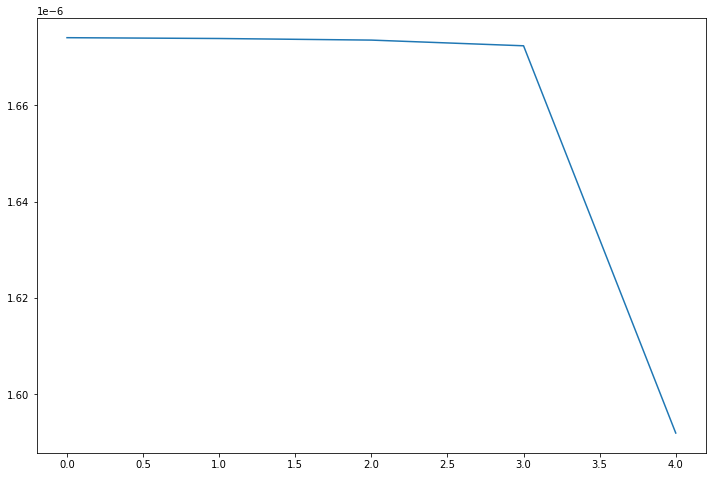

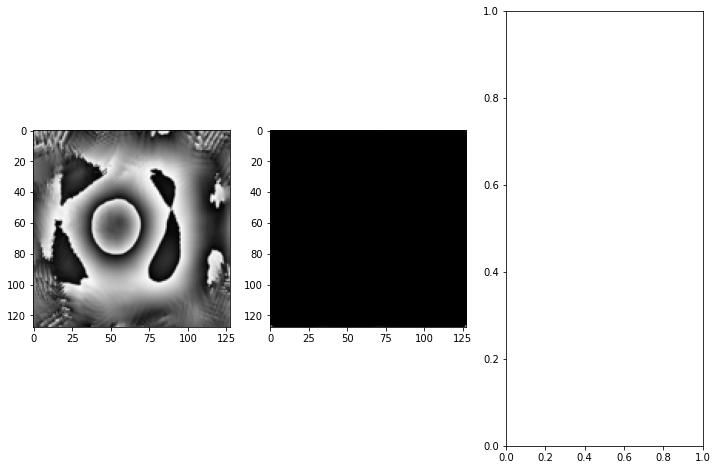

In [19]:
##We import the code's libraries
import math
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

#We define the model that will be used as convolutional autoencoder (based on u-net)
def build_model(input_layer, start_neurons):
    # Start set of U-NET
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle set of U-NET
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    # Final set of U-NET
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    #OUTPUT
    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1) / 255

    return output_layer

#Here we define our Sequence train dataset
class SequenceDataset(Sequence):

    def __init__(self, x_set, y_set, batch_size=32):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return (np.array([np.expand_dims(imread(file_name, as_gray=True) / 255., axis=2) for file_name in batch_x]),
                np.array([np.expand_dims(imread(file_name, as_gray=True) / 255., axis=2) for file_name in batch_y]))

#class ValidationDataset(Sequence):
    
    #def __init__(self, x_val, y_val, batch_size=32):
       # self.x, self.y = x_val, y_val
        #self.batch_size = batch_size

    #def __len__(self):
     #   return math.ceil(len(self.x) / self.batch_size)

    #def __getitem__(self, idx):
       # batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
       # batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

       # return (np.array([np.expand_dims(imread(file_name, as_gray=True) / 255., axis=2) for file_name in batch_x]),
              #  np.array([np.expand_dims(imread(file_name, as_gray=True) / 255., axis=2) for file_name in batch_y]))

#This is the mathematical relation used to our created wrapped images
def wrap_image(img):
    return np.angle(np.exp(1j * np.array(img)))

#Here we use the library OS to import our train dataset
def load_images():
    real_directory = 'dataset/unwrapped'
    wrapped_directory = 'dataset/wrapped'
    inputs = []
    targets = []
    for filename in os.listdir(real_directory):
        real_file = f'{real_directory}/{filename}'
        wrapped_file = f'{wrapped_directory}/{filename}'

        img = load_img(real_file, color_mode='grayscale')
        real_img = np.expand_dims(np.asarray(img) / 255, axis=2)

        img = load_img(wrapped_file, color_mode='grayscale')
        wrapped_img = np.expand_dims(np.asarray(img) / 255, axis=2)

        targets.append(real_img)
        inputs.append(wrapped_img)

    return np.array(inputs, dtype='float32'), np.array(targets, dtype='float32')

#Here we use the library OS to import our test dataset
def load_val_images():
    valreal_directory = 'valset/unwrapped'
    valwrapped_directory = 'valset/wrapped'
    inputs = []
    targets = []
    for filename in os.listdir(valreal_directory):
        valreal_file = f'{valreal_directory}/{filename}'
        valwrapped_file = f'{valwrapped_directory}/{filename}'

        img_val = load_img(valreal_file, color_mode='grayscale')
        valreal_img = np.expand_dims(np.asarray(img_val) / 255, axis=2)

        img_val = load_img(valwrapped_file, color_mode='grayscale')
        valwrapped_img = np.expand_dims(np.asarray(img_val) / 255, axis=2)

        targets.append(valreal_img)
        inputs.append(valwrapped_img)

    return np.array(inputs, dtype='float32'), np.array(targets, dtype='float32')   

#batch_size=32
#x_val, y_val = load_val_images()
#valreal_directory = 'valset/unwrapped' 
#valwrapped_directory = 'valset/wrapped' 
#valwrapped_files = os.listdir(valwrapped_directory) 
#valreal_files = os.listdir(valreal_directory) 

#x_val = [f'{valwrapped_directory}/{file}' for file in valwrapped_files if file in valreal_files]
#y_val = [f'{valreal_directory}/{file}' for file in valwrapped_files if file in valwrapped_files]



#val_sequence = ValidationDataset(x_val, y_val, batch_size=batch_size)


# x, y = load_images()
real_directory = 'dataset/unwrapped'
wrapped_directory = 'dataset/wrapped'
wrapped_files = os.listdir(wrapped_directory)
real_files = os.listdir(real_directory)

x_set = [f'{wrapped_directory}/{file}' for file in wrapped_files if file in real_files] 
y_set = [f'{real_directory}/{file}' for file in wrapped_files if file in wrapped_files] 

sequence = SequenceDataset(x_set, y_set, batch_size=batch_size)

input_layer = Input((128, 128, 1))
#input_layer = Input((240, 240, 1))
output_layer = build_model(input_layer, 16)
unet = Model(input_layer, output_layer)

unet.compile(optimizer="adam", loss="mse", metrics = ["mse"])

# unet = load_model('data/models/128x128.h5')
#history = unet.fit(sequence, epochs=2, validation_data=[x_val, y_val])
history = unet.fit(sequence, batch_size=32, epochs=2)

unet.save(f'dataset/models/128x128.h5')

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
#plt.plot(history.history)['val_loss']
#plt.plot(history.history['accuracy'])
    
#plt.savefig('data/plots/loss.png')

for file in os.listdir(f'dataset/wrapped')[:10]:
   img = load_img(f'dataset/wrapped/{file}', color_mode='grayscale')
   wrapped_img = np.expand_dims(np.asarray(img) / 255, axis=2)
   predicted_img = unet.predict(np.array([wrapped_img]))
   predicted_img = predicted_img.reshape(predicted_img.shape[1], predicted_img.shape[2])

   img = load_img(f'dataset/unwrapped/{file}', color_mode='grayscale')
   real_img = np.asarray(img) / 255

   fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
   fig.set_size_inches(12, 8)
   ax1.imshow(wrapped_img.reshape(predicted_img.shape[0], predicted_img.shape[1]), cmap='gray')
   ax2.imshow(real_img, cmap='gray')
   ax3.imshow(predicted_img, cmap='gray')
   #plt.savefig(f'data/plots/{file}')


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **THIS CODE GENERATE THE WRAPPED AND UNWRAPPED IMAGES DATASET FOR THE CONVOLUTIONAL AUTOENCODER**

In [6]:
#Basado en: Manuel Montoya Zuluaga, ingeniero físico, Universidad EAFIT.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from random import randint, choice


def operate_terms(x, y, cross_term, c, function_list, x_terms=True, y_terms=True, cross_terms=True, multiply=True):
    if multiply:
        mod = 1
    else:
        mod = 0

    if x_terms:
        img1 = function_list[c % len(function_list)](x)
        c += 1
    else:
        img1 = mod

    if y_terms:
        img2 = function_list[c % len(function_list)](y)
        c += 1
    else:
        img2 = mod

    if cross_terms:
        img3 = function_list[c % len(function_list)](cross_term)
        c += 1
    else:
        img3 = mod

    if multiply:
        img = img1 * img2 * img3
    else:
        img = img1 + img2 + img3

    return img, c


def generate_image(x, y, nmax, operation, function_list, multiply=True, **kwargs):
    operations = {
        0: x + y,
        1: x - y,
        2: x * y,
        3: x / y
    }

    c = 0
    img, c = operate_terms(x, y, operations[operation], c, function_list, **kwargs, multiply=multiply)

    while c < len(function_list):
        new_img, c = operate_terms(x, y, operations[operation], c, function_list, **kwargs, multiply=multiply)
        if multiply:
            img *= new_img
        else:
            img += new_img

    img = img / abs(img).max() * nmax
    return img


if __name__ == '__main__':
    data_folder = 'dataset'
    real_folder = 'unwrapped'
    wrapped_folder = 'wrapped'
    n_images = 100000
    start_number = 1
    img_size = 128
    size = complex(f'{img_size}j')

    if data_folder not in os.listdir('.'):
        os.mkdir(data_folder)

    if real_folder not in os.listdir(data_folder):
        os.mkdir(os.path.join(data_folder, real_folder))

    if wrapped_folder not in os.listdir(data_folder):
        os.mkdir(os.path.join(data_folder, wrapped_folder))

    x, y = np.mgrid[-1:1:size, -1:1:size]
    nmax = 2 * np.pi
    # nmax = 11 * np.pi  # 5 phase wrappings

    function_list = [
        np.sin,
        np.cos
    ]

    x_variations = [
        x,
        x ** 2,
    ]

    y_variations = [
        y,
        y ** 2,
    ]

    for n in range(n_images):
        # x_factor = randint(-5, 5)
        x_factor = randint(-3, 3)
        if x_factor == 0:
            x_factor = 1

        # y_factor = randint(-5, 5)
        y_factor = randint(-3, 3)
        if y_factor == 0:
            y_factor = 1

        nm = nmax
        # nm = nmax / randint(1, 5)

        f_list = []
        for i in range(randint(2, 3)):
            f_list.append(choice(function_list))

        # multiply = bool(randint(0, 1))
        multiply = True
        x_terms = bool(randint(0, 1))
        y_terms = bool(randint(0, 1))
        cross_terms = False
        # cross_terms = bool(randint(0, 1))
        operation = 2
        # operation = randint(0, 3)

        while not x_terms and not y_terms and not cross_terms:
            x_terms = bool(randint(0, 1))
            y_terms = bool(randint(0, 1))
            cross_terms = bool(randint(0, 1))

        img = generate_image(choice(x_variations) * x_factor, choice(y_variations) * y_factor, nm, operation, f_list,
                             multiply=multiply, x_terms=x_terms, y_terms=y_terms, cross_terms=cross_terms)

        # img = generate_image(x * x_factor, y * y_factor, nm, operation, f_list,
        #                      multiply=multiply, x_terms=x_terms, y_terms=y_terms, cross_terms=cross_terms)

        filename = f'{n + start_number}.png'
        plt.imsave(os.path.join(data_folder, real_folder, filename), img, cmap='gray')
        plt.close()

        wrapped_img = np.angle(np.exp(1j * img))
        plt.imsave(os.path.join(data_folder, wrapped_folder, filename), wrapped_img, cmap='gray')
        plt.close()


**IN THIS PART WE LOAD UP OUR TRAINED MODEL FOR PREDICT REAL WRAPPED IMAGES**


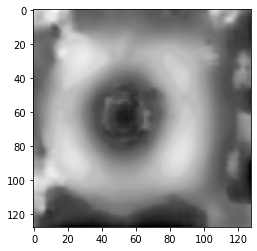

In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize


unet = load_model('dataset/models/128x128_35000.h5')
shape = (128, 128)


img = load_img('/content/phase_wrapp/5.png', color_mode='grayscale')
img_array = img_to_array(img)
new_img = resize(img_array, shape)

plt.imsave('dataset/plots/test3_wrapped.png', new_img.reshape(shape), cmap='gray')
#plt.imshow(new_img, cmap='gray')
#plt.show()

wrapped_img = new_img / 255
predicted_img = unet.predict(np.array([wrapped_img]))
predicted_img = predicted_img.reshape(shape)

plt.imsave('dataset/plots/test3_predicted.png', predicted_img, cmap='gray')
plt.imshow(predicted_img, cmap='gray')
plt.show()